#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


## Lab. 06 - Transfer Learning

In this lab. we will start from a network wich has already been trained, trying to transfer some of the knowledge previously gained to a similar but more specific task. 

In particular, the netowork has been originally trained to solve a multi-class classification problem over 1,000 different categories. We will try to specialize the network on just 4 targeted classes, taking training data from a different dataset.

ORIGINAL NETWORK

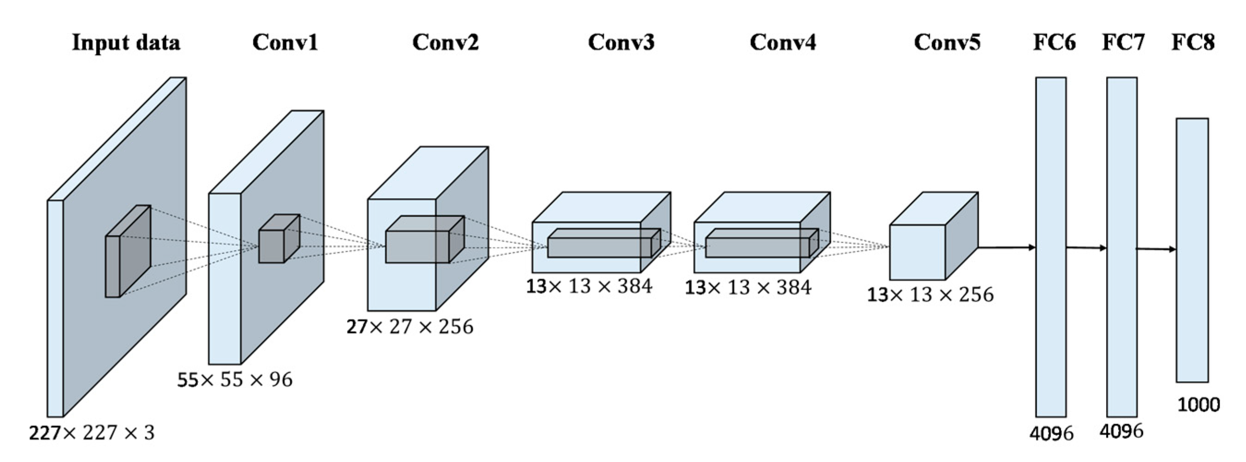

MODIFIED ARCHITECTURE

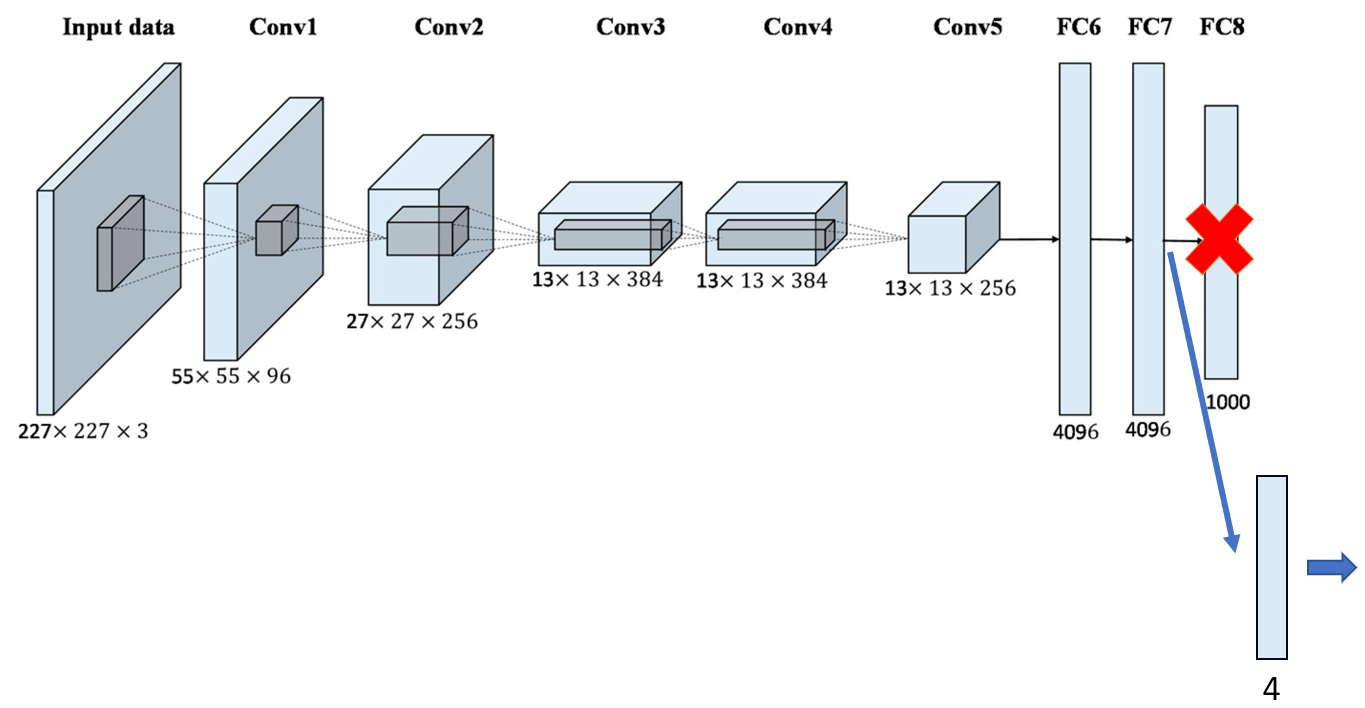

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px # this is another plotting library for interactive plot

from sklearn.model_selection import train_test_split
from sklearn import metrics, manifold # we will use the metrics and manifold learning modules from scikit-learn
from pathlib import Path # to interact with file paths
from PIL import Image # to interact with images
from tqdm import tqdm # progress bar
from pprint import pprint # pretty print (useful for a more readable print of objects like lists or dictionaries)

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Dataset

## Data download 

This cell download a txt file "imagenet1000_clsid_to_human.txt" containing the class name of the pretrained network. Take a look on the file in the local *Files* section.

In [2]:
!wget https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/imagenet1000_clsid_to_human.txt

--2021-03-02 21:58:36--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/imagenet1000_clsid_to_human.txt
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsid_to_human.txt’

imagenet1000_clsid_ 100%[===================>]  29.85K  --.-KB/s    in 0.1s    

2021-03-02 21:58:37 (301 KB/s) - ‘imagenet1000_clsid_to_human.txt’ saved [30564/30564]



This cell installs the library [*openimages*](https://github.com/monocongo/openimages) in the Colab environment through the pip package repository. This is just a utiliy library that will be used only to download the train and test images.

In [3]:
!pip install openimages

     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 133kB 21.3MB/s 
     |████████████████████████████████| 296kB 42.7MB/s 
     |████████████████████████████████| 144.2MB 83kB/s 
     |████████████████████████████████| 7.3MB 45.2MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
ERROR: botocore 1.20.19 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


Let's donwnload some images from the openimage dataset (https://storage.googleapis.com/openimages/web/index.html).

This cell downloads images of the specified classes, and saves them in the `dest_dir` local folder.

In [4]:
from openimages.download import download_images
images_location = download_images(
    dest_dir='dataset',
    class_labels=['Muffin', 'Aircraft', 'Apple', 'Cat'],
    exclusions_path=None,
    csv_dir=None,
    limit=1000,
)

2021-03-02  21:59:32 INFO NumExpr defaulting to 2 threads.
2021-03-02  21:59:35 INFO Downloading 552 train images for class 'muffin'
100%|██████████| 552/552 [00:05<00:00, 96.83it/s]
2021-03-02  21:59:40 INFO Downloading 473 train images for class 'aircraft'
100%|██████████| 473/473 [00:04<00:00, 98.91it/s]
2021-03-02  21:59:45 INFO Downloading 312 train images for class 'apple'
100%|██████████| 312/312 [00:03<00:00, 96.24it/s]
2021-03-02  21:59:49 INFO Downloading 1000 train images for class 'cat'
100%|██████████| 1000/1000 [00:10<00:00, 98.14it/s]
2021-03-02  22:00:00 INFO Downloading 19 validation images for class 'muffin'
100%|██████████| 19/19 [00:00<00:00, 44.23it/s]
2021-03-02  22:00:01 INFO Downloading 62 validation images for class 'aircraft'
100%|██████████| 62/62 [00:01<00:00, 48.48it/s]
2021-03-02  22:00:02 INFO Downloading 23 validation images for class 'apple'
100%|██████████| 23/23 [00:00<00:00, 41.13it/s]
2021-03-02  22:00:04 INFO Downloading 55 test images for class 'm

The ouput of the previous function is a dictionary where the keys represent the class names and the values are the locations of the just downloaded images.

This will be useful to create our dataset.

In [5]:
pprint(images_location)

{'aircraft': 'dataset/aircraft/images',
 'apple': 'dataset/apple/images',
 'cat': 'dataset/cat/images',
 'muffin': 'dataset/muffin/images'}


Finally, we need to associate each class to an id:

In [6]:
# Dictionary containing the mapping from label name to ID
label_to_id = {
  'aircraft': 0,
  'apple': 1,
  'cat': 2,
  'muffin': 3
}
# Dictionary containing the mapping from ID to label name
id_to_label = {id: label for label, id in label_to_id.items()}

print('label_to_id =', label_to_id)
print('id_to_label =', id_to_label)

label_to_id = {'aircraft': 0, 'apple': 1, 'cat': 2, 'muffin': 3}
id_to_label = {0: 'aircraft', 1: 'apple', 2: 'cat', 3: 'muffin'}


## Train/Test split

First of all, let's create a list containing all the available samples. Each element of the list is a tuple where the first element is the path of the image, and the second element is the corresponding class name.

For convenience, we are using the python `pathlib` library (https://docs.python.org/3/library/pathlib.html) to interact with local filepaths, in particular the `Path` class. This allows to write OS independent code, and it also has very practical utility methods.

In [7]:
# List all images
all_samples = [] # Initialize the list
for label_name, dir in images_location.items(): # Iterate through the location of the downloaded images folders (the dictionary returned by the download_images function above)
  label = label_to_id[label_name] # Convert the label name to the label ID
  for filepath in Path(dir).iterdir(): # Iterate through the files inside the directory (.iterdir)
    all_samples.append((filepath, label)) # Append the filepath and the label to the list
all_samples.sort() # Sort the list (to be sure that the order of the samples is always the same for the following train/test split)

pprint(all_samples[:10]) # pprint stands for "pretty print", this is just for a more readable print of some objects

[(PosixPath('dataset/aircraft/images/00144844bdaf8351.jpg'), 0),
 (PosixPath('dataset/aircraft/images/0021ea873f2e416e.jpg'), 0),
 (PosixPath('dataset/aircraft/images/0023b0e23b369b8d.jpg'), 0),
 (PosixPath('dataset/aircraft/images/002ff6e1eecb80b8.jpg'), 0),
 (PosixPath('dataset/aircraft/images/003b2d3c807da35f.jpg'), 0),
 (PosixPath('dataset/aircraft/images/0057f6a4bf6997a9.jpg'), 0),
 (PosixPath('dataset/aircraft/images/006130a7fc2e99cc.jpg'), 0),
 (PosixPath('dataset/aircraft/images/008b0ea15dfca327.jpg'), 0),
 (PosixPath('dataset/aircraft/images/00ef6583b9a09e4e.jpg'), 0),
 (PosixPath('dataset/aircraft/images/00f7f375379ee063.jpg'), 0)]


Now we first keep a 20% of data for testing. The remaining 80% of data is further divided in train and validation.

The `stratify` parameter ensures that the fraction of data for each class will be as equal as possibile among the splits.


In [8]:
# Create the test set (20%)
train_samples, test_samples = train_test_split(all_samples, test_size=0.2, stratify=[s[1] for s in all_samples], shuffle=True, random_state=0)
# Create the train (80%) and validation set (20%) from the remaining data
train_samples, val_samples = train_test_split(train_samples, test_size=0.2, stratify=[s[1] for s in train_samples], shuffle=True, random_state=0)

print("--- TRAIN SAMPLES ---")
print(pd.DataFrame(train_samples)[1].value_counts()) # The "value_counts()" method of pandas DataFrame allows easily count the number of samples for each class
print("\n--- TRAIN SAMPLES (PERCENTAGE) ---")
print(pd.DataFrame(train_samples)[1].value_counts() / len(train_samples) * 100) 

print("\n--- VALIDATION SAMPLES ---")
print(pd.DataFrame(val_samples)[1].value_counts())
print("\n--- VALIDATION SAMPLES (PERCENTAGE) ---")
print(pd.DataFrame(val_samples)[1].value_counts() / len(val_samples) * 100) 

print("\n--- TEST SAMPLES ---")
print(pd.DataFrame(test_samples)[1].value_counts())
print("\n--- TEST SAMPLES (PERCENTAGE) ---")
print(pd.DataFrame(test_samples)[1].value_counts() / len(test_samples) * 100) 

--- TRAIN SAMPLES ---
2    640
0    456
3    401
1    249
Name: 1, dtype: int64

--- TRAIN SAMPLES (PERCENTAGE) ---
2    36.655212
0    26.116838
3    22.966781
1    14.261168
Name: 1, dtype: float64

--- VALIDATION SAMPLES ---
2    160
0    115
3    100
1     62
Name: 1, dtype: int64

--- VALIDATION SAMPLES (PERCENTAGE) ---
2    36.613272
0    26.315789
3    22.883295
1    14.187643
Name: 1, dtype: float64

--- TEST SAMPLES ---
2    200
0    143
3    125
1     78
Name: 1, dtype: int64

--- TEST SAMPLES (PERCENTAGE) ---
2    36.630037
0    26.190476
3    22.893773
1    14.285714
Name: 1, dtype: float64


## Dataset class

The dataset class just needs to store the samples list, and load the corresponding image when required.

The suggested way to load images is through the `PIL` library. The following code load, decode and sotre an image as a PIL Image object:

```
from PIL import Image
image = Image.open(image_path)
```

The dataset returns both the decoded image (PIL format), possibly transformed, and the corresponding label.

In [9]:
class ImageDataset(Dataset):
    
    def __init__(self, samples, transform=None):
      """
      samples: list of samples where each element is a tuple (image_path, class_name)
      """
      self.samples = samples
      self.transform = transform

    def __len__(self):
      return len(self.samples)

    def __getitem__(self, idx):
      # Get the corresponding sample
      image_path, label = self.samples[idx]

      # Load as PIL image
      image = Image.open(image_path).convert('RGB')

      # Apply transformations (to the image only)
      if self.transform:
          image = self.transform(image)

      return (image, label)

### Datasets initialization

In [10]:
train_dataset = ImageDataset(train_samples)
val_dataset   = ImageDataset(val_samples)
test_dataset  = ImageDataset(test_samples)

SAMPLE AT INDEX 0
LABEL: 2
LABEL NAME: cat


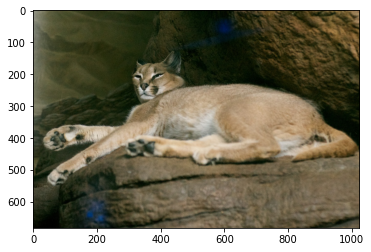

In [11]:
# Test if it works
index = 0
image, label = train_dataset[index]
print(f"SAMPLE AT INDEX {index}")
print(f"LABEL: {label}")
print(f"LABEL NAME: {id_to_label[label]}")
plt.imshow(image)

## Data transformation

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`

### Test transformation pipeline

In [12]:
scale = 224
input_shape = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

test_trans = transforms.Compose([
        transforms.Resize(scale), # This resize the image, but keep the proportion
        # transforms.CenterCrop(input_shape), # This crop the image at the center, ensuring the given shape (you need to enable this layer to increase the test or validation batch size)
        transforms.ToTensor(), # Convert to tensor
        transforms.Normalize(mean=mean, std=std), # Normalize the values to match the ones used for the pre-trained network
        ])

ORIGINAL IMAGE SHAPE: (707, 1024, 3)
TRANSFORMED IMAGE SHAPE: torch.Size([3, 224, 324])
tensor([[[-0.1486, -0.1314, -0.1314,  ...,  0.0398, -0.0972, -0.1657],
         [-0.1143, -0.0972, -0.0972,  ...,  0.0741,  0.0056,  0.0056],
         [-0.0287, -0.0458, -0.0629,  ...,  0.0056, -0.0629, -0.0116],
         ...,
         [-0.0116,  0.0569,  0.0056,  ..., -1.9980, -2.0323, -2.0665],
         [-0.0287,  0.0398,  0.0912,  ..., -2.0494, -2.0665, -2.0837],
         [ 0.0227,  0.0569,  0.1083,  ..., -2.0665, -2.0837, -2.0665]],

        [[-0.0749, -0.0574, -0.1099,  ..., -0.0924, -0.1975, -0.1275],
         [-0.0574, -0.0399, -0.0749,  ..., -0.0749, -0.0924, -0.0574],
         [-0.0224, -0.0224, -0.0574,  ..., -0.0749, -0.0924,  0.0651],
         ...,
         [ 0.2927,  0.2927,  0.3102,  ..., -1.4230, -1.4930, -1.4930],
         [ 0.3277,  0.3277,  0.3102,  ..., -1.4755, -1.5105, -1.5105],
         [ 0.2927,  0.3102,  0.3452,  ..., -1.4755, -1.4930, -1.5280]],

        [[ 0.0082, -0.0615, 

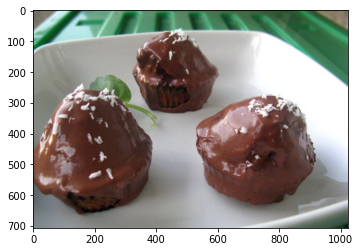

2021-03-02  22:00:56 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TRANSFORMED IMAGE


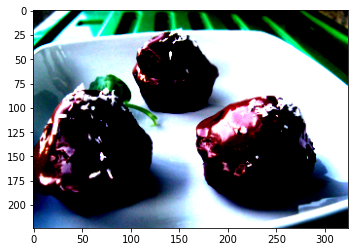

In [13]:
# Test if it works
original_image = train_dataset[1][0]
transformed_image = test_trans(original_image)
print(f"ORIGINAL IMAGE SHAPE: {np.array(original_image).shape}")
print(f"TRANSFORMED IMAGE SHAPE: {transformed_image.shape}")
print(transformed_image)

# Plot original image
print('ORIGINAL IMAGE')
plt.imshow(original_image)
plt.show()

# Plot transformed image
print('TRANSFORMED IMAGE')
plt.imshow(transformed_image.permute([1,2,0]))
plt.show()

### Train transformation pipeline

In [14]:
# Train transformation pipeline
scale = 300
train_trans = transforms.Compose([
        transforms.Resize(scale),  # This resize the image, but keep the proportion
        transforms.RandomRotation([-45, 45]),  # This apply a random rotation to the image
        transforms.RandomCrop(input_shape),  # This apply a random crop to the image, ensuring the proper shape
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        ])

ORIGINAL IMAGE SHAPE: (707, 1024, 3)
TRANSFORMED IMAGE SHAPE: torch.Size([3, 224, 224])
tensor([[[ 0.3481,  0.5193,  0.4851,  ...,  1.3242,  1.2385,  1.2728],
         [ 0.4166,  0.4679,  0.4337,  ...,  1.3242,  1.3070,  1.2899],
         [ 0.4337,  0.4337,  0.4337,  ...,  1.3242,  1.2728,  1.2728],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -0.5424, -0.5767, -0.4739],
         [-2.1179, -2.1179, -2.1179,  ..., -0.4397, -0.5253, -0.4226],
         [-2.1179, -2.1179, -2.1179,  ..., -0.3027, -0.3883, -0.3198]],

        [[ 0.6254,  0.6429,  0.6429,  ...,  1.3957,  1.4132,  1.3782],
         [ 0.6254,  0.6429,  0.6779,  ...,  1.3957,  1.3957,  1.3606],
         [ 0.5728,  0.5728,  0.6254,  ...,  1.3606,  1.3431,  1.3431],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -0.4076, -0.5826, -0.5301],
         [-2.0357, -2.0357, -2.0357,  ..., -0.3025, -0.3725, -0.3901],
         [-2.0357, -2.0357, -2.0357,  ..., -0.2150, -0.2850, -0.3025]],

        [[ 0.6356,  0.7054, 

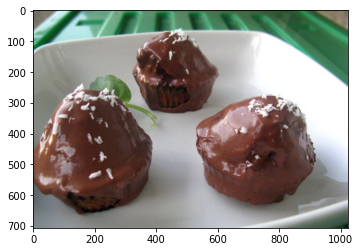

2021-03-02  22:01:00 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TRANSFORMED IMAGE


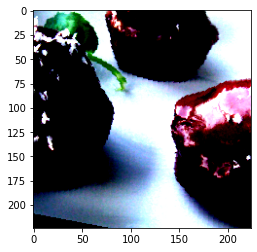

In [15]:
# Test if it works
original_image = train_dataset[1][0]
transformed_image = train_trans(original_image)
print(f"ORIGINAL IMAGE SHAPE: {np.array(original_image).shape}")
print(f"TRANSFORMED IMAGE SHAPE: {transformed_image.shape}")
print(transformed_image)

# Plot original image
print('ORIGINAL IMAGE')
plt.imshow(original_image)
plt.show()

# Plot transformed image
print('TRANSFORMED IMAGE')
plt.imshow(transformed_image.permute([1,2,0]))
plt.show()

Update the dataset with the proper transformation

In [16]:
# Redefine the datasets with the proper transform
train_dataset.transform = train_trans
val_dataset.transform   = test_trans
test_dataset.transform  = test_trans

### Create the dataloader

In this case we can consider to use multiple workers to load data concurrently. 

Since we are loading and decoding images from disk, this may be a bottleneck.

In [17]:
# Dataloader
train_dataloader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True,  num_workers=8)
val_dataloader   = DataLoader(dataset=val_dataset,   batch_size=1,  shuffle=False, num_workers=8)
test_dataloader  = DataLoader(dataset=test_dataset,  batch_size=1,  shuffle=False, num_workers=8)

In [18]:
### Test if it works
# Train batch
image_batch, label_batch = next(iter(train_dataloader))
print(f"\nTrain input batch shape: {image_batch.shape}")
print(f"Train label batch shape: {label_batch.shape}")

# Validation batch
image_batch, label_batch = next(iter(val_dataloader))
print(f"\nValidation input batch shape: {image_batch.shape}")
print(f"Validation label batch shape: {label_batch.shape}")

# Test batch
image_batch, label_batch = next(iter(test_dataloader))
print(f"\nTest input batch shape: {image_batch.shape}")
print(f"Test label batch shape: {label_batch.shape}")


Train input batch shape: torch.Size([50, 3, 224, 224])
Train label batch shape: torch.Size([50])

Validation input batch shape: torch.Size([1, 3, 224, 335])
Validation label batch shape: torch.Size([1])

Test input batch shape: torch.Size([1, 3, 224, 224])
Test label batch shape: torch.Size([1])


# Network

## Import the pretrained network

Some of the most used architectures are available in the PyTorch [models](https://pytorch.org/docs/stable/torchvision/models.html) library.

In this example we use the AlexNet architecture, presented in one of the most influential paper in the computer vision field (https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

PyTorch also provides (optionally) pretrained weights, clearly required for a transfer learning. The network has been trained to classify images among 1000 different categories, using data from the famous ImageNet dataset.

In [19]:
### Import the pretrained network
net = torchvision.models.alexnet(pretrained=True)
# Print the network architecture
print(net)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


## Analyze the pretrained network

### Accessing network layers

In [20]:
# Example: access a specific layer
print(net.features[6])

Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [21]:
# Example: access the weight of the third convolutional layer
print(net.features[6].weight)

Parameter containing:
tensor([[[[ 2.4858e-02,  1.3116e-02,  2.8198e-02],
          [ 4.2541e-02,  5.7339e-02, -6.0905e-03],
          [-4.1912e-03,  9.3096e-03, -1.5442e-02]],

         [[-3.8954e-03, -7.8586e-02, -5.1808e-02],
          [ 2.6484e-02, -4.9877e-02, -1.7763e-03],
          [ 8.2902e-03, -4.9339e-02,  3.1145e-02]],

         [[ 1.6455e-02, -1.2150e-02,  1.7428e-02],
          [ 5.2012e-02, -6.7141e-03,  2.7325e-02],
          [ 7.5568e-03, -4.2402e-02, -2.7909e-02]],

         ...,

         [[-1.7289e-04,  2.4099e-02,  3.6948e-02],
          [-2.4145e-02, -3.5276e-02,  3.6910e-03],
          [ 1.9541e-02, -3.0342e-02, -3.5262e-02]],

         [[ 1.3239e-02, -1.8624e-02, -5.3330e-02],
          [ 1.7639e-04, -1.4714e-02, -2.2829e-02],
          [-6.7702e-03,  2.3287e-02,  1.3873e-02]],

         [[ 3.0512e-02,  7.5860e-03,  4.9459e-04],
          [-4.5703e-03, -1.2827e-02, -6.5061e-03],
          [-9.8111e-03, -1.5570e-02,  1.9379e-02]]],


        [[[ 1.3660e-02, -3.9180

### Pretrained network output

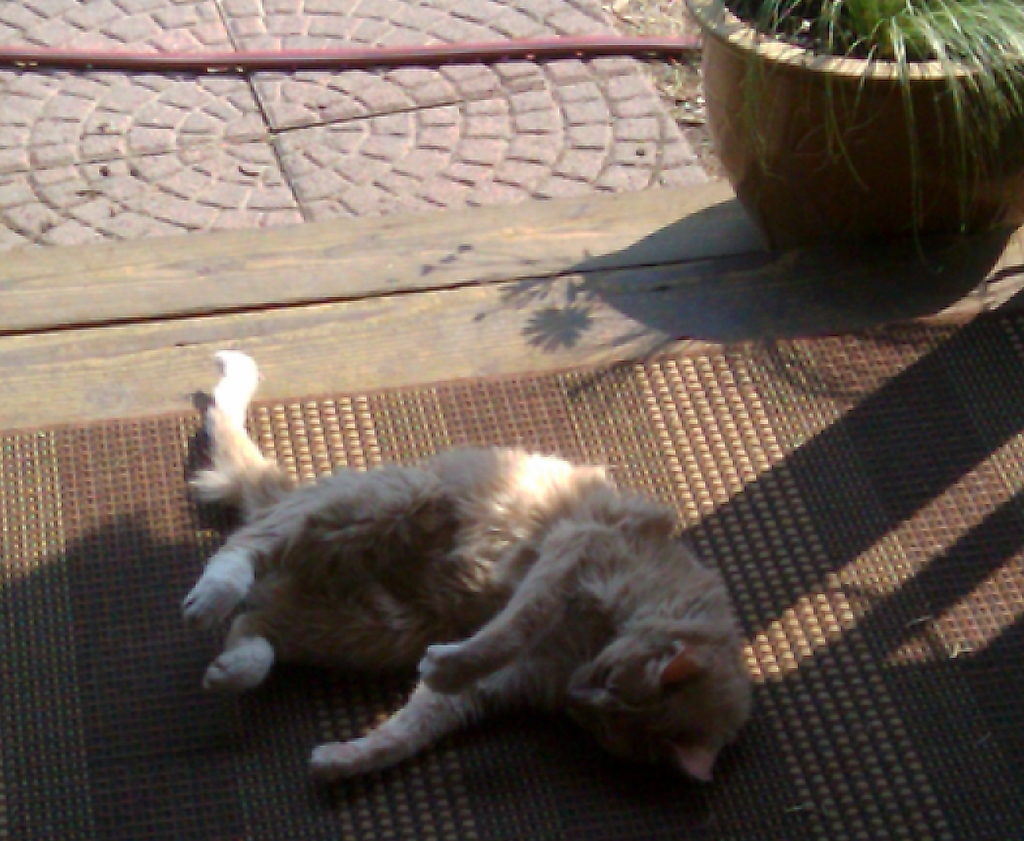

In [22]:
### Check the network output
# Get an image from our dataset
index = 2
sample_image, sample_label = val_dataset[index]
sample_image = sample_image.unsqueeze(0)

Image.open(val_dataset.samples[index][0])

In [23]:
# Evaluate the pretrained network output
net.eval()
with torch.no_grad(): # Disable gradient tracking
    out = net(sample_image)

print(f"INPUT SHAPE: {sample_image.shape}")
print(f"OUTPUT SHAPE: {out.shape}")

INPUT SHAPE: torch.Size([1, 3, 224, 272])
OUTPUT SHAPE: torch.Size([1, 1000])


In [24]:
# Plot directly the network output
fig = px.bar(y=out.flatten().cpu().numpy())
fig.update_layout(
    xaxis_title='Class Index',
    yaxis_title='Linear Network Output'
)

In [25]:
# Apply a softmax to the network output
softmax_out = torch.nn.functional.softmax(out)
softmax_out = softmax_out.flatten().cpu().numpy()

fig = px.bar(y=softmax_out)
fig.update_layout(
    xaxis_title='Class Index',
    yaxis_title='Softmax Network Output'
)

In [26]:
### Check the 10 most probable classes

# Load human readable classes
with open('imagenet1000_clsid_to_human.txt', 'r') as f:
    dict_text = f.read()
    id_to_human = eval(dict_text)

pprint(id_to_human)

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon '
    'carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Amb

In [27]:
# Top 10 classes
top10_class_id = softmax_out.argsort()[::-1][:10] # Sort in descending order and take the first 10 elements
for idx in top10_class_id:
  print(f"{100 * softmax_out[idx]:.1f}% - Class: {id_to_human[idx]} (class index: {idx})")

7.8% - Class: Cardigan, Cardigan Welsh corgi (class index: 264)
7.5% - Class: lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens (class index: 387)
3.3% - Class: beagle (class index: 162)
3.1% - Class: English setter (class index: 212)
3.0% - Class: tabby, tabby cat (class index: 281)
2.7% - Class: Madagascar cat, ring-tailed lemur, Lemur catta (class index: 383)
2.4% - Class: common iguana, iguana, Iguana iguana (class index: 39)
2.2% - Class: Shetland sheepdog, Shetland sheep dog, Shetland (class index: 230)
2.2% - Class: spindle (class index: 816)
2.2% - Class: polecat, fitch, foulmart, foumart, Mustela putorius (class index: 358)


# Transfer learning

In [28]:
# Print original network structure
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Disable the parameters update

In [29]:
# Disallow the update of all the layers by setting the 'requires_grad' parameter of the tensors to 'False'
for param_name, param in net.named_parameters():
    print(param_name)
    print('\tFreezing update')
    param.requires_grad = False

features.0.weight
	Freezing update
features.0.bias
	Freezing update
features.3.weight
	Freezing update
features.3.bias
	Freezing update
features.6.weight
	Freezing update
features.6.bias
	Freezing update
features.8.weight
	Freezing update
features.8.bias
	Freezing update
features.10.weight
	Freezing update
features.10.bias
	Freezing update
classifier.1.weight
	Freezing update
classifier.1.bias
	Freezing update
classifier.4.weight
	Freezing update
classifier.4.bias
	Freezing update
classifier.6.weight
	Freezing update
classifier.6.bias
	Freezing update


### Modify the architecture

In [30]:
# Change the last layer to match the new reduced problem    
num_classes = 4
net.classifier[6] = torch.nn.Linear(4096, num_classes)
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Enable the parameters update for specific layers

In [31]:
# Allow the training of the last two layers (classifier[4] and classifier[6])
for param in net.classifier[4].parameters():
    param.requires_grad = True 
for param in net.classifier[6].parameters():
    param.requires_grad = True 

In [32]:
# Check if correct
for param_name, param in net.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

features.0.weight 	- requires_grad=False
features.0.bias 	- requires_grad=False
features.3.weight 	- requires_grad=False
features.3.bias 	- requires_grad=False
features.6.weight 	- requires_grad=False
features.6.bias 	- requires_grad=False
features.8.weight 	- requires_grad=False
features.8.bias 	- requires_grad=False
features.10.weight 	- requires_grad=False
features.10.bias 	- requires_grad=False
classifier.1.weight 	- requires_grad=False
classifier.1.bias 	- requires_grad=False
classifier.4.weight 	- requires_grad=True
classifier.4.bias 	- requires_grad=True
classifier.6.weight 	- requires_grad=True
classifier.6.bias 	- requires_grad=True


# Training

## Loss and Optimizer

In [33]:
# Define a loss function (CrossEntropyLoss)
loss_fn = torch.nn.CrossEntropyLoss()

# Define an optimizer
lr = 1e-3
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=5e-4)

# Select the proper device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move all the network parameters to the selected device
net.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Training function

In [34]:
### Training function
def train_epoch(net, device, dataloader, loss_fn, optimizer):
    # Set train mode
    net.train()
    for image_batch, label_batch in dataloader:
        # Move tensors to the selected device
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        # Forward pass
        out = net(image_batch)
        # Evaluate loss
        loss = loss_fn(out, label_batch)
        # Backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print loss
        print('\t Training loss (single batch):', float(loss.data))

## Testing function

In [35]:
### Testing function
def test_epoch(net, device, dataloader, loss_fn):
    # Set evaluation mode
    net.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, label_batch in tqdm(dataloader):
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            # Forward pass
            out = net(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(out)
            conc_label.append(label_batch)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return conc_out, conc_label, val_loss.data # We return all the outputs, all the labels and the global loss

## Training loop (fine-tuning)

In [36]:
### Training cycle
num_epochs = 20
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    print(f"EPOCH {epoch + 1}/{num_epochs}")
    ### Training (use the training function)
    train_epoch(
        net=net,
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    
    ### Train loss (use the TESTING function! We want the train loss but using the network in eval mode and without random transformations)
    _, _, train_loss = test_epoch(
        net=net,
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn)
    # Print Train loss
    print(f"\n\n\t TRAIN - EPOCH {epoch + 1}/{num_epochs} - train loss: {train_loss}\n\n")
    train_losses.append(train_loss)

    ### Validation  (use the testing function)
    _, _, val_loss = test_epoch(
        net=net,
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    # Print Validation loss
    print(f"\n\n\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - val loss: {val_loss}\n\n")
    val_losses.append(val_loss)

    ### Save model parameters
    torch.save(net.state_dict(), 'finetuned_model.pth')

EPOCH 1/20
	 Training loss (single batch): 1.7668195962905884
	 Training loss (single batch): 2.2096822261810303
	 Training loss (single batch): 0.6542906761169434
	 Training loss (single batch): 0.5102805495262146
	 Training loss (single batch): 0.5686345100402832
	 Training loss (single batch): 0.6108644008636475
	 Training loss (single batch): 1.193304181098938
	 Training loss (single batch): 0.7452625036239624
	 Training loss (single batch): 0.09788014739751816
	 Training loss (single batch): 0.48837757110595703
	 Training loss (single batch): 0.8512845039367676
	 Training loss (single batch): 0.3500705361366272
	 Training loss (single batch): 0.9811332821846008
	 Training loss (single batch): 0.49456527829170227
	 Training loss (single batch): 1.0351732969284058
	 Training loss (single batch): 0.7022724747657776
	 Training loss (single batch): 0.5340825319290161
	 Training loss (single batch): 0.6385470032691956
	 Training loss (single batch): 0.6750370860099792
	 Training loss (s

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 1/20 - train loss: 0.26205843687057495




100%|██████████| 437/437 [00:08<00:00, 51.13it/s]




	 VALIDATION - EPOCH 1/20 - val loss: 0.3416251838207245


EPOCH 2/20
	 Training loss (single batch): 0.12641654908657074
	 Training loss (single batch): 0.4113196134567261
	 Training loss (single batch): 0.13773684203624725
	 Training loss (single batch): 0.4576285183429718
	 Training loss (single batch): 0.14557813107967377
	 Training loss (single batch): 0.41087454557418823
	 Training loss (single batch): 0.423030287027359
	 Training loss (single batch): 0.26384782791137695
	 Training loss (single batch): 0.12713684141635895
	 Training loss (single batch): 0.3286890387535095
	 Training loss (single batch): 0.34016311168670654
	 Training loss (single batch): 0.26572173833847046
	 Training loss (single batch): 0.16397245228290558
	 Training loss (single batch): 0.674373984336853
	 Training loss (single batch): 0.31827160716056824
	 Training loss (single batch): 0.23196712136268616
	 Training loss (single batch): 0.59813392162323
	 Training loss (single batch): 0.051745131611824036
	

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 2/20 - train loss: 0.18778850138187408




100%|██████████| 437/437 [00:08<00:00, 51.38it/s]




	 VALIDATION - EPOCH 2/20 - val loss: 0.6079070568084717


EPOCH 3/20
	 Training loss (single batch): 0.4518904387950897
	 Training loss (single batch): 0.3847135901451111
	 Training loss (single batch): 0.26201361417770386
	 Training loss (single batch): 0.39451703429222107
	 Training loss (single batch): 0.23189222812652588
	 Training loss (single batch): 0.2825460433959961
	 Training loss (single batch): 0.11684881150722504
	 Training loss (single batch): 0.1418912559747696
	 Training loss (single batch): 0.11791879683732986
	 Training loss (single batch): 0.07728676497936249
	 Training loss (single batch): 0.3050903081893921
	 Training loss (single batch): 0.23711484670639038
	 Training loss (single batch): 0.21240031719207764
	 Training loss (single batch): 0.14469264447689056
	 Training loss (single batch): 0.2253439575433731
	 Training loss (single batch): 0.05415358021855354
	 Training loss (single batch): 0.09618303924798965
	 Training loss (single batch): 0.2488289028406143

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 3/20 - train loss: 0.10371392220258713




100%|██████████| 437/437 [00:08<00:00, 51.35it/s]




	 VALIDATION - EPOCH 3/20 - val loss: 0.27839335799217224


EPOCH 4/20
	 Training loss (single batch): 0.12614375352859497
	 Training loss (single batch): 0.09316527098417282
	 Training loss (single batch): 0.17241206765174866
	 Training loss (single batch): 0.17504598200321198
	 Training loss (single batch): 0.07681646943092346
	 Training loss (single batch): 0.18456894159317017
	 Training loss (single batch): 0.07640611380338669
	 Training loss (single batch): 0.2616865634918213
	 Training loss (single batch): 0.14324985444545746
	 Training loss (single batch): 0.06767863780260086
	 Training loss (single batch): 0.14145754277706146
	 Training loss (single batch): 0.2302400767803192
	 Training loss (single batch): 0.03583052009344101
	 Training loss (single batch): 0.03200645372271538
	 Training loss (single batch): 0.20028576254844666
	 Training loss (single batch): 0.19336169958114624
	 Training loss (single batch): 0.22750642895698547
	 Training loss (single batch): 0.09027552604

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 4/20 - train loss: 0.09567459672689438




100%|██████████| 437/437 [00:08<00:00, 51.07it/s]




	 VALIDATION - EPOCH 4/20 - val loss: 0.3131508231163025


EPOCH 5/20
	 Training loss (single batch): 0.05858365446329117
	 Training loss (single batch): 0.10854773223400116
	 Training loss (single batch): 0.19644460082054138
	 Training loss (single batch): 0.16918060183525085
	 Training loss (single batch): 0.2361481487751007
	 Training loss (single batch): 0.1756048947572708
	 Training loss (single batch): 0.18382707238197327
	 Training loss (single batch): 0.05398760363459587
	 Training loss (single batch): 0.16245883703231812
	 Training loss (single batch): 0.14816702902317047
	 Training loss (single batch): 0.042354486882686615
	 Training loss (single batch): 0.027610914781689644
	 Training loss (single batch): 0.16542768478393555
	 Training loss (single batch): 0.12823712825775146
	 Training loss (single batch): 0.24590247869491577
	 Training loss (single batch): 0.11027441918849945
	 Training loss (single batch): 0.017412429675459862
	 Training loss (single batch): 0.376311898

  0%|          | 0/35 [00:00<?, ?it/s]

	 Training loss (single batch): 0.1550970822572708


  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 5/20 - train loss: 0.08085793256759644




100%|██████████| 437/437 [00:08<00:00, 51.36it/s]




	 VALIDATION - EPOCH 5/20 - val loss: 0.31362244486808777


EPOCH 6/20
	 Training loss (single batch): 0.08400746434926987
	 Training loss (single batch): 0.23929031193256378
	 Training loss (single batch): 0.28004172444343567
	 Training loss (single batch): 0.041281286627054214
	 Training loss (single batch): 0.16164131462574005
	 Training loss (single batch): 0.10834041237831116
	 Training loss (single batch): 0.06882920861244202
	 Training loss (single batch): 0.24295996129512787
	 Training loss (single batch): 0.016264677047729492
	 Training loss (single batch): 0.03170362487435341
	 Training loss (single batch): 0.021136462688446045
	 Training loss (single batch): 0.2716524600982666
	 Training loss (single batch): 0.08815986663103104
	 Training loss (single batch): 0.21545429527759552
	 Training loss (single batch): 0.08014988899230957
	 Training loss (single batch): 0.0685485303401947
	 Training loss (single batch): 0.11578474193811417
	 Training loss (single batch): 0.25465393

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 6/20 - train loss: 0.11948168277740479




100%|██████████| 437/437 [00:08<00:00, 51.40it/s]




	 VALIDATION - EPOCH 6/20 - val loss: 0.3053320348262787


EPOCH 7/20
	 Training loss (single batch): 0.08837976306676865
	 Training loss (single batch): 0.25999030470848083
	 Training loss (single batch): 0.04345501959323883
	 Training loss (single batch): 0.5937950015068054
	 Training loss (single batch): 0.18870395421981812
	 Training loss (single batch): 0.13605810701847076
	 Training loss (single batch): 0.19692450761795044
	 Training loss (single batch): 0.1045544221997261
	 Training loss (single batch): 0.22294403612613678
	 Training loss (single batch): 0.078868068754673
	 Training loss (single batch): 0.24632029235363007
	 Training loss (single batch): 0.04421468824148178
	 Training loss (single batch): 0.055419933050870895
	 Training loss (single batch): 0.1834319531917572
	 Training loss (single batch): 0.11730391532182693
	 Training loss (single batch): 0.10109680891036987
	 Training loss (single batch): 0.14614185690879822
	 Training loss (single batch): 0.03461706265807

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 7/20 - train loss: 0.08566311001777649




100%|██████████| 437/437 [00:08<00:00, 51.97it/s]




	 VALIDATION - EPOCH 7/20 - val loss: 0.29349541664123535


EPOCH 8/20
	 Training loss (single batch): 0.18368753790855408
	 Training loss (single batch): 0.09089089184999466
	 Training loss (single batch): 0.06917984783649445
	 Training loss (single batch): 0.2413548231124878
	 Training loss (single batch): 0.10786493122577667
	 Training loss (single batch): 0.1964610069990158
	 Training loss (single batch): 0.10609406232833862
	 Training loss (single batch): 0.0836247131228447
	 Training loss (single batch): 0.06192905083298683
	 Training loss (single batch): 0.08954600989818573
	 Training loss (single batch): 0.18596923351287842
	 Training loss (single batch): 0.08145399391651154
	 Training loss (single batch): 0.3181613087654114
	 Training loss (single batch): 0.2877372205257416
	 Training loss (single batch): 0.18380995094776154
	 Training loss (single batch): 0.22052696347236633
	 Training loss (single batch): 0.16082428395748138
	 Training loss (single batch): 0.27956062555313

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 8/20 - train loss: 0.12400171905755997




100%|██████████| 437/437 [00:08<00:00, 51.24it/s]




	 VALIDATION - EPOCH 8/20 - val loss: 0.28451693058013916


EPOCH 9/20
	 Training loss (single batch): 0.06672701984643936
	 Training loss (single batch): 0.32894763350486755
	 Training loss (single batch): 0.08868294954299927
	 Training loss (single batch): 0.08947768062353134
	 Training loss (single batch): 0.4296591877937317
	 Training loss (single batch): 0.14637474715709686
	 Training loss (single batch): 0.10681227594614029
	 Training loss (single batch): 0.43162545561790466
	 Training loss (single batch): 0.183413565158844
	 Training loss (single batch): 0.1701849102973938
	 Training loss (single batch): 0.322797954082489
	 Training loss (single batch): 0.04968985542654991
	 Training loss (single batch): 0.06452412158250809
	 Training loss (single batch): 0.036660220474004745
	 Training loss (single batch): 0.03239235654473305
	 Training loss (single batch): 0.07721491158008575
	 Training loss (single batch): 0.28109103441238403
	 Training loss (single batch): 0.06849990040063

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 9/20 - train loss: 0.07873854041099548




100%|██████████| 437/437 [00:08<00:00, 51.81it/s]




	 VALIDATION - EPOCH 9/20 - val loss: 0.31633177399635315


EPOCH 10/20
	 Training loss (single batch): 0.219329372048378
	 Training loss (single batch): 0.2420749068260193
	 Training loss (single batch): 0.08491404354572296
	 Training loss (single batch): 0.06372738629579544
	 Training loss (single batch): 0.06427228450775146
	 Training loss (single batch): 0.010270847007632256
	 Training loss (single batch): 0.09587652236223221
	 Training loss (single batch): 0.125457763671875
	 Training loss (single batch): 0.046441949903964996
	 Training loss (single batch): 0.10069775581359863
	 Training loss (single batch): 0.16185630857944489
	 Training loss (single batch): 0.058184489607810974
	 Training loss (single batch): 0.0452943816781044
	 Training loss (single batch): 0.10719706863164902
	 Training loss (single batch): 0.18784937262535095
	 Training loss (single batch): 0.06501054763793945
	 Training loss (single batch): 0.24527211487293243
	 Training loss (single batch): 0.25553423166

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 10/20 - train loss: 0.09935300052165985




100%|██████████| 437/437 [00:08<00:00, 53.15it/s]




	 VALIDATION - EPOCH 10/20 - val loss: 0.35093042254447937


EPOCH 11/20
	 Training loss (single batch): 0.09728710353374481
	 Training loss (single batch): 0.13824474811553955
	 Training loss (single batch): 0.25692179799079895
	 Training loss (single batch): 0.02521805837750435
	 Training loss (single batch): 0.09145978093147278
	 Training loss (single batch): 0.10555028170347214
	 Training loss (single batch): 0.07701312750577927
	 Training loss (single batch): 0.039898961782455444
	 Training loss (single batch): 0.0972445085644722
	 Training loss (single batch): 0.2493612915277481
	 Training loss (single batch): 0.045017145574092865
	 Training loss (single batch): 0.376412570476532
	 Training loss (single batch): 0.1052846908569336
	 Training loss (single batch): 0.11011027544736862
	 Training loss (single batch): 0.06392265111207962
	 Training loss (single batch): 0.08764868974685669
	 Training loss (single batch): 0.1390010118484497
	 Training loss (single batch): 0.27956521511

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 11/20 - train loss: 0.07137560844421387




100%|██████████| 437/437 [00:08<00:00, 52.66it/s]




	 VALIDATION - EPOCH 11/20 - val loss: 0.28016263246536255


EPOCH 12/20
	 Training loss (single batch): 0.029103977605700493
	 Training loss (single batch): 0.12229438126087189
	 Training loss (single batch): 0.13174353539943695
	 Training loss (single batch): 0.04260087385773659
	 Training loss (single batch): 0.041875142604112625
	 Training loss (single batch): 0.1553068608045578
	 Training loss (single batch): 0.11030993610620499
	 Training loss (single batch): 0.08838092535734177
	 Training loss (single batch): 0.05331644043326378
	 Training loss (single batch): 0.029612883925437927
	 Training loss (single batch): 0.030711568892002106
	 Training loss (single batch): 0.01776055246591568
	 Training loss (single batch): 0.06033680588006973
	 Training loss (single batch): 0.19588357210159302
	 Training loss (single batch): 0.06716220080852509
	 Training loss (single batch): 0.10569316148757935
	 Training loss (single batch): 0.05423106998205185
	 Training loss (single batch): 0.1107

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 12/20 - train loss: 0.07171054184436798




100%|██████████| 437/437 [00:08<00:00, 52.21it/s]




	 VALIDATION - EPOCH 12/20 - val loss: 0.36103054881095886


EPOCH 13/20
	 Training loss (single batch): 0.104647696018219
	 Training loss (single batch): 0.04065617918968201
	 Training loss (single batch): 0.039547596126794815
	 Training loss (single batch): 0.09539754688739777
	 Training loss (single batch): 0.029315456748008728
	 Training loss (single batch): 0.06995312124490738
	 Training loss (single batch): 0.14849711954593658
	 Training loss (single batch): 0.18768711388111115
	 Training loss (single batch): 0.01501582469791174
	 Training loss (single batch): 0.014408723451197147
	 Training loss (single batch): 0.07930082082748413
	 Training loss (single batch): 0.03648373484611511
	 Training loss (single batch): 0.09316263347864151
	 Training loss (single batch): 0.5610958337783813
	 Training loss (single batch): 0.02887507528066635
	 Training loss (single batch): 0.04132290929555893
	 Training loss (single batch): 0.07663511484861374
	 Training loss (single batch): 0.0367925

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 13/20 - train loss: 0.039879247546195984




100%|██████████| 437/437 [00:08<00:00, 51.35it/s]




	 VALIDATION - EPOCH 13/20 - val loss: 0.26316744089126587


EPOCH 14/20
	 Training loss (single batch): 0.10098273307085037
	 Training loss (single batch): 0.17179061472415924
	 Training loss (single batch): 0.18013602495193481
	 Training loss (single batch): 0.28159192204475403
	 Training loss (single batch): 0.046208109706640244
	 Training loss (single batch): 0.11629827320575714
	 Training loss (single batch): 0.16236162185668945
	 Training loss (single batch): 0.15723666548728943
	 Training loss (single batch): 0.03983718529343605
	 Training loss (single batch): 0.3278934955596924
	 Training loss (single batch): 0.1511128544807434
	 Training loss (single batch): 0.029657507315278053
	 Training loss (single batch): 0.06706931442022324
	 Training loss (single batch): 0.1480792760848999
	 Training loss (single batch): 0.1902659386396408
	 Training loss (single batch): 0.21520081162452698
	 Training loss (single batch): 0.04054174944758415
	 Training loss (single batch): 0.180451095

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 14/20 - train loss: 0.05610911175608635




100%|██████████| 437/437 [00:08<00:00, 52.16it/s]




	 VALIDATION - EPOCH 14/20 - val loss: 0.29120996594429016


EPOCH 15/20
	 Training loss (single batch): 0.14518722891807556
	 Training loss (single batch): 0.1445990949869156
	 Training loss (single batch): 0.16779768466949463
	 Training loss (single batch): 0.03198166936635971
	 Training loss (single batch): 0.10030317306518555
	 Training loss (single batch): 0.24656468629837036
	 Training loss (single batch): 0.2419736236333847
	 Training loss (single batch): 0.17017337679862976
	 Training loss (single batch): 0.1218334212899208
	 Training loss (single batch): 0.2820260226726532
	 Training loss (single batch): 0.17333021759986877
	 Training loss (single batch): 0.07688929885625839
	 Training loss (single batch): 0.14107030630111694
	 Training loss (single batch): 0.2716394364833832
	 Training loss (single batch): 0.011852859519422054
	 Training loss (single batch): 0.1540505290031433
	 Training loss (single batch): 0.03749948367476463
	 Training loss (single batch): 0.018393998965

  0%|          | 0/35 [00:00<?, ?it/s]

	 Training loss (single batch): 0.27053338289260864


  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 15/20 - train loss: 0.05320924147963524




100%|██████████| 437/437 [00:08<00:00, 51.45it/s]




	 VALIDATION - EPOCH 15/20 - val loss: 0.31350308656692505


EPOCH 16/20
	 Training loss (single batch): 0.09550193697214127
	 Training loss (single batch): 0.01620194874703884
	 Training loss (single batch): 0.04522780328989029
	 Training loss (single batch): 0.09005632996559143
	 Training loss (single batch): 0.3634481132030487
	 Training loss (single batch): 0.14624671638011932
	 Training loss (single batch): 0.3666646182537079
	 Training loss (single batch): 0.23408199846744537
	 Training loss (single batch): 0.1622268110513687
	 Training loss (single batch): 0.38851264119148254
	 Training loss (single batch): 0.1791297346353531
	 Training loss (single batch): 0.1797293871641159
	 Training loss (single batch): 0.24463944137096405
	 Training loss (single batch): 0.39435702562332153
	 Training loss (single batch): 0.2810925245285034
	 Training loss (single batch): 0.05992339551448822
	 Training loss (single batch): 0.07402209937572479
	 Training loss (single batch): 0.0915392711758

  0%|          | 0/35 [00:00<?, ?it/s]

	 Training loss (single batch): 0.06157698854804039


  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 16/20 - train loss: 0.059246134012937546




100%|██████████| 437/437 [00:08<00:00, 52.45it/s]




	 VALIDATION - EPOCH 16/20 - val loss: 0.3041017949581146


EPOCH 17/20
	 Training loss (single batch): 0.06048554927110672
	 Training loss (single batch): 0.11504310369491577
	 Training loss (single batch): 0.12806560099124908
	 Training loss (single batch): 0.14252126216888428
	 Training loss (single batch): 0.0654107928276062
	 Training loss (single batch): 0.06560583412647247
	 Training loss (single batch): 0.18987397849559784
	 Training loss (single batch): 0.1798972487449646
	 Training loss (single batch): 0.06864307075738907
	 Training loss (single batch): 0.07484505325555801
	 Training loss (single batch): 0.17735585570335388
	 Training loss (single batch): 0.23652403056621552
	 Training loss (single batch): 0.12940827012062073
	 Training loss (single batch): 0.05973405763506889
	 Training loss (single batch): 0.07213995605707169
	 Training loss (single batch): 0.1476951539516449
	 Training loss (single batch): 0.11265651881694794
	 Training loss (single batch): 0.19195163249

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 17/20 - train loss: 0.08693964034318924




100%|██████████| 437/437 [00:08<00:00, 51.43it/s]




	 VALIDATION - EPOCH 17/20 - val loss: 0.41283199191093445


EPOCH 18/20
	 Training loss (single batch): 0.13698983192443848
	 Training loss (single batch): 0.21711528301239014
	 Training loss (single batch): 0.07402161508798599
	 Training loss (single batch): 0.006001488771289587
	 Training loss (single batch): 0.1042417511343956
	 Training loss (single batch): 0.05922595039010048
	 Training loss (single batch): 0.34736692905426025
	 Training loss (single batch): 0.0520915761590004
	 Training loss (single batch): 0.10972471535205841
	 Training loss (single batch): 0.06362612545490265
	 Training loss (single batch): 0.11188513040542603
	 Training loss (single batch): 0.3437160849571228
	 Training loss (single batch): 0.024704692885279655
	 Training loss (single batch): 0.12810058891773224
	 Training loss (single batch): 0.037988919764757156
	 Training loss (single batch): 0.03720248118042946
	 Training loss (single batch): 0.21362555027008057
	 Training loss (single batch): 0.2723709

  0%|          | 0/35 [00:00<?, ?it/s]

	 Training loss (single batch): 0.15297125279903412


  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 18/20 - train loss: 0.14517980813980103




100%|██████████| 437/437 [00:08<00:00, 52.06it/s]




	 VALIDATION - EPOCH 18/20 - val loss: 0.43925175070762634


EPOCH 19/20
	 Training loss (single batch): 0.29258444905281067
	 Training loss (single batch): 0.1102282926440239
	 Training loss (single batch): 0.2985045909881592
	 Training loss (single batch): 0.28253117203712463
	 Training loss (single batch): 0.22540611028671265
	 Training loss (single batch): 0.055667344480752945
	 Training loss (single batch): 0.048977065831422806
	 Training loss (single batch): 0.1475832611322403
	 Training loss (single batch): 0.3790241479873657
	 Training loss (single batch): 0.0216249730437994
	 Training loss (single batch): 0.1665118783712387
	 Training loss (single batch): 0.12000931799411774
	 Training loss (single batch): 0.031163208186626434
	 Training loss (single batch): 0.06624983251094818
	 Training loss (single batch): 0.053997017443180084
	 Training loss (single batch): 0.08408038318157196
	 Training loss (single batch): 0.03432519733905792
	 Training loss (single batch): 0.027911985

  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 19/20 - train loss: 0.07390449941158295




100%|██████████| 437/437 [00:08<00:00, 52.51it/s]




	 VALIDATION - EPOCH 19/20 - val loss: 0.28906282782554626


EPOCH 20/20
	 Training loss (single batch): 0.10776779800653458
	 Training loss (single batch): 0.052548907697200775
	 Training loss (single batch): 0.10860881209373474
	 Training loss (single batch): 0.08539137244224548
	 Training loss (single batch): 0.16610030829906464
	 Training loss (single batch): 0.0553097277879715
	 Training loss (single batch): 0.16325008869171143
	 Training loss (single batch): 0.12132902443408966
	 Training loss (single batch): 0.17456015944480896
	 Training loss (single batch): 0.4520898759365082
	 Training loss (single batch): 0.12222784012556076
	 Training loss (single batch): 0.014361471869051456
	 Training loss (single batch): 0.08797662705183029
	 Training loss (single batch): 0.07212970405817032
	 Training loss (single batch): 0.1546369343996048
	 Training loss (single batch): 0.1485465168952942
	 Training loss (single batch): 0.022325243800878525
	 Training loss (single batch): 0.08048448

  0%|          | 0/35 [00:00<?, ?it/s]

	 Training loss (single batch): 0.13658280670642853
	 Training loss (single batch): 0.16720378398895264


  0%|          | 0/437 [00:00<?, ?it/s]



	 TRAIN - EPOCH 20/20 - train loss: 0.04581022262573242




100%|██████████| 437/437 [00:08<00:00, 52.52it/s]




	 VALIDATION - EPOCH 20/20 - val loss: 0.27081435918807983




# Result analysis

In [37]:
# Load saved parameters
net.load_state_dict(torch.load('finetuned_model.pth'))

<All keys matched successfully>

## Final test

In [38]:
### Test loss
test_outputs, test_labels, test_loss = test_epoch(
    net=net,
    device=device, 
    dataloader=test_dataloader, 
    loss_fn=loss_fn)
# Print Test loss
print(f"\n\nTEST LOSS : {test_loss}")

100%|██████████| 546/546 [00:10<00:00, 50.70it/s]



TEST LOSS : 0.2661072909832001


## Confusion matrix

In [39]:
### Confusion matrix
# Predicted labels
y_true = test_labels.cpu().data.numpy()
y_pred = test_outputs.cpu().argmax(dim=1).numpy()
# Evaluate confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
# Show the confusion matrix
pd.DataFrame(cm)

0   1    2    3
0  140   0    3    0
1    4  63    3    8
2    2   2  194    2
3    1   8    5  111

## Analyze network weights

In [40]:
# Print network architecture
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

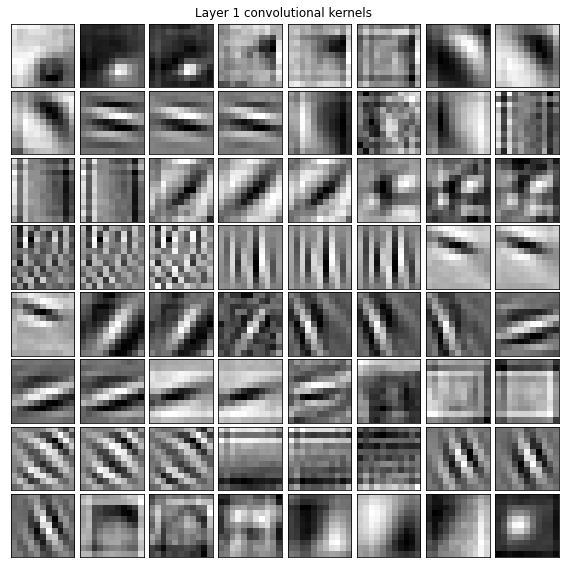

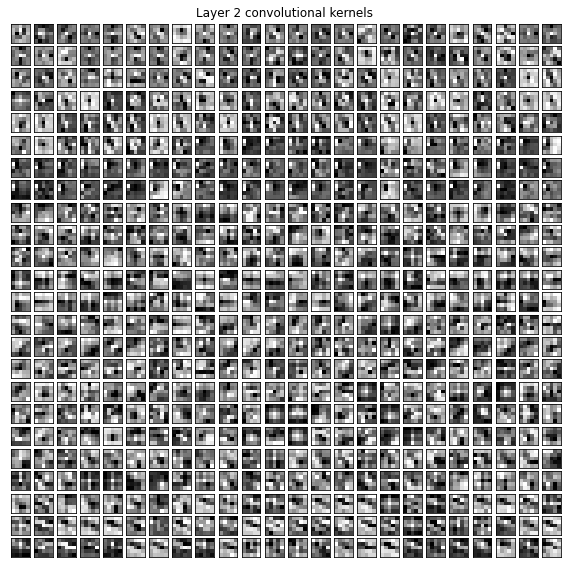

In [41]:
### Extract weights 
# Layer 1 weights
weights_l1 = net.features[0].weight.data.cpu().numpy()
# Layer 2 weights
weights_l2 = net.features[3].weight.data.cpu().numpy()

### Plot the weights (this is a utility function, no need to analyze this code)
def plot_nchw_data(data, h_num, v_num, title):
    fig, axs = plt.subplots(h_num, v_num, figsize=(8,8))
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()

plot_nchw_data(weights_l1, 8, 8, 'Layer 1 convolutional kernels')
plot_nchw_data(weights_l2, 24, 24, 'Layer 2 convolutional kernels')


## Analyze activations

Register the forward hooks

In [42]:
# Hook function to call during forward pass
def hook_fn(module, input, output):
    intermediate_outputs.append(output)

# Attach hook function to all the convolutional layers
hook_handles = [] # This list will contains all the handles required to remove the hooks later
hook_handles.append(net.features[1].register_forward_hook(hook_fn))
hook_handles.append(net.features[4].register_forward_hook(hook_fn))
hook_handles.append(net.features[7].register_forward_hook(hook_fn))
hook_handles.append(net.features[9].register_forward_hook(hook_fn))
hook_handles.append(net.features[11].register_forward_hook(hook_fn))

Analyze the activations for a single input image

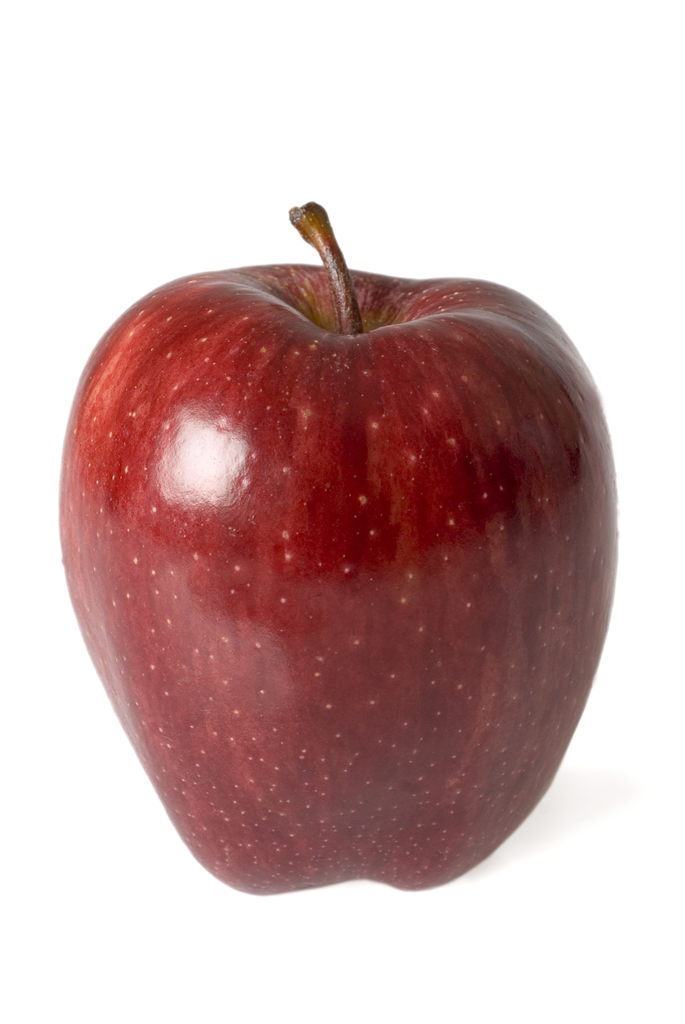

In [43]:
# Define input
net_input = test_dataset[1][0].unsqueeze(0)
net_input = net_input.to(device)

# Show original image
Image.open(test_dataset.samples[1][0])

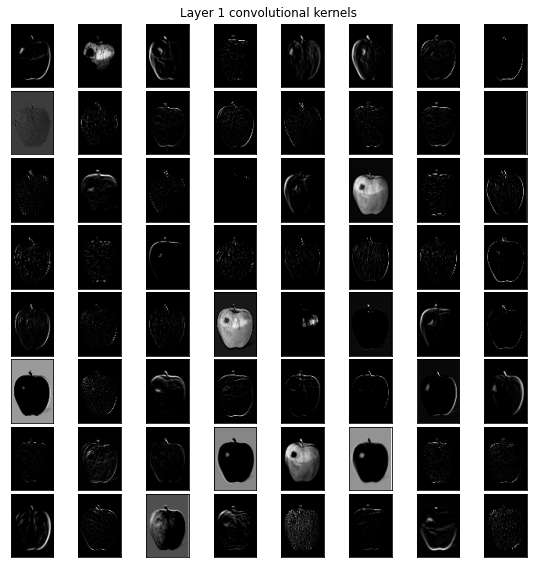

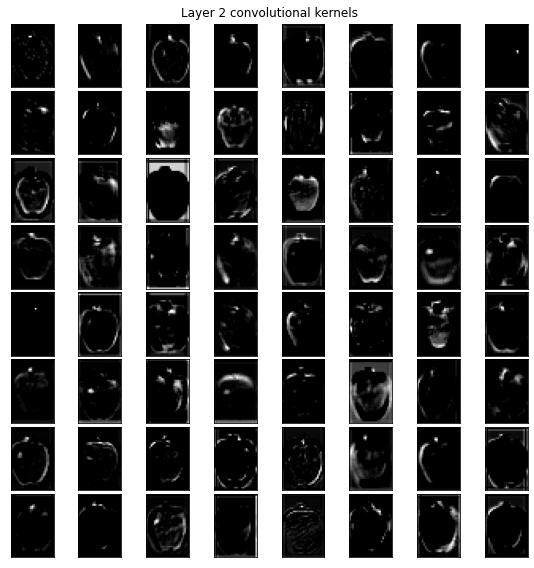

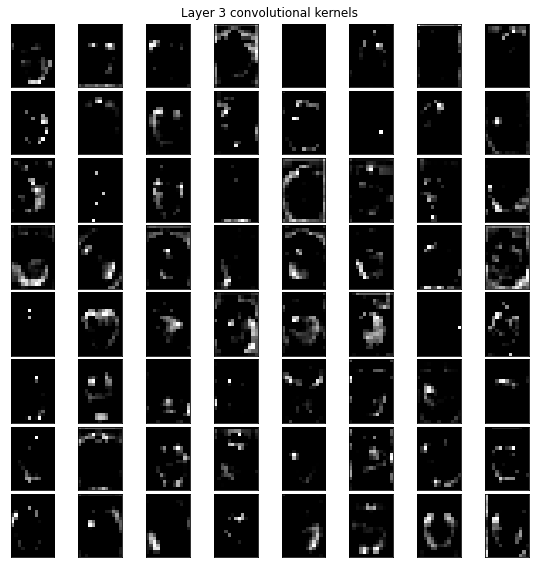

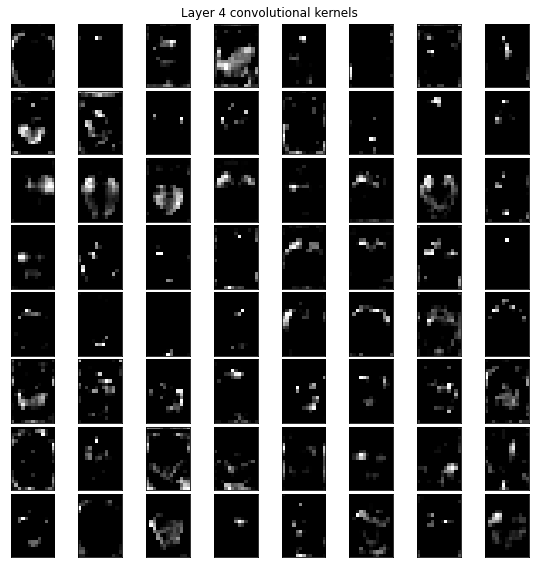

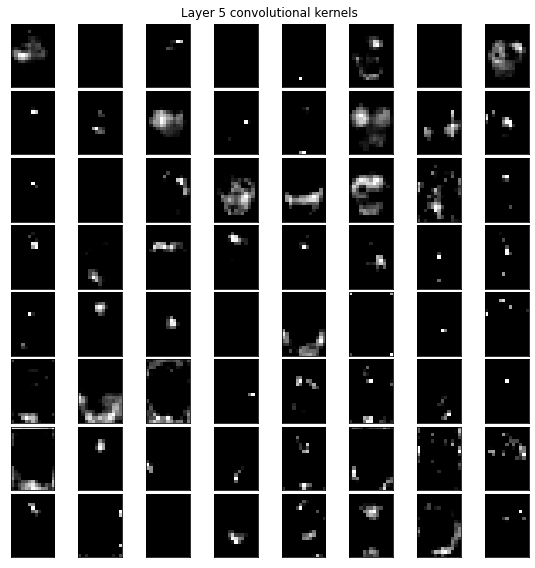

In [44]:
# Evaluate output
net.eval()
with torch.no_grad():
    intermediate_outputs = []
    out = net(net_input)
    # Now the intermediate_outputs list contains the intermediate outputs thanks to the hook function

# Analyze intermediate outputs
for layer_num, intermediate_output in enumerate(intermediate_outputs):
    intermediate_output = intermediate_output.cpu().data.numpy()
    # Plot
    plot_nchw_data(intermediate_output, 8, 8, 'Layer %d convolutional kernels' % (layer_num + 1))

Remove the registered forward hooks

In [46]:
# Remove the hooks using the handles saved during the hooks definition
for handle in hook_handles:
  handle.remove()

## Bidimensional space visualization

Here we want to analyze the output of second last layer of the network (4096 different neurons in this architecture). This is typically considered the *feature space*, since the last layer uses the information stored in these variables to perform the final classification.

A good feature space contains samples of different classes well spearated each other, and samples of the same class clustered together.

Since we cannot visualize such a high dimensional space, we need dimensionality reduction techniques to have an idea about this condition.

In [47]:
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

First, we need another forward hook to register the output of the second last layer.

In [49]:
# Hook function to call during forward pass (extract second last layer features)
def hook_feature_space(module, input, output):
    feature_space.append(output) # feature_space must be a list defined before evaluating the network output

# Attach the hook function to layer classifier[5]
hook_handle = net.classifier[5].register_forward_hook(hook_feature_space)

Since we now have the hook registered, when we evaluate the test outputs the `feature_space` list will be updated with the feature space values corresponding to the test samples.

In [50]:
feature_space = [] # This list will be filled by the feature space values

### Analyze all the test samples
test_outputs, test_labels, test_loss = test_epoch(
    net=net,
    device=device, 
    dataloader=test_dataloader, 
    loss_fn=loss_fn)

# Concatenate all the features in a single tensor
feature_space = torch.cat(feature_space)

100%|██████████| 546/546 [00:11<00:00, 49.32it/s]


Let's verify if the list has been populated.

In [51]:
print(feature_space.shape)

torch.Size([1092, 4096])


Since the following analyses won't use PyTorch, let's move everything back to CPU.

In [52]:
feature_space = feature_space.cpu()
test_labels   = test_labels.cpu()
test_outputs  = test_outputs.cpu()

### t-distributed Stochastic Neighbor Embedding

t-SNE [[ref]](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In [53]:
### t-SNE embedding of the dataset (t-distributed Stochastic Neighbor Embedding)
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
feature_space_tsne = tsne.fit_transform(feature_space)

Computing t-SNE embedding


In [54]:
print(f"FEATURE SPACE SHAPE: {feature_space.shape}")
print(f"FEATURE SPACE SHAPE (TSNE): {feature_space_tsne.shape}")

FEATURE SPACE SHAPE: torch.Size([1092, 4096])
FEATURE SPACE SHAPE (TSNE): (1092, 2)


Let's prepare a pandas dataframe just for plotting (no need to analyze this code)

In [55]:
# Prepare dataframe for plotting (no need to analyze this code)
df = pd.DataFrame(feature_space_tsne)
df['label'] = test_labels
df['label_name'] = df.label.apply(lambda l: id_to_label[l])
df

ValueError: ignored

In [ ]:
### Plot
px.scatter(df, x=0, y=1, color='label_name', hover_data=[df.index])

We can check what are the samples that falls in the wrong cluster to see if the error may be considered "reasonable" or the network is completely wrong.

In [ ]:
Image.open(test_dataset.samples[122][0])

### Isomap embedding

We can do the same thing with different type of dimensionality reduction methods, such as [Isometric Mapping Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html).

In [ ]:
### Isomap embedding of the dataset
print("Computing Isomap")
isomap = manifold.Isomap(n_components=2)
feature_space_isomap = isomap.fit_transform(feature_space)

In [ ]:
print(f"FEATURE SPACE SHAPE: {feature_space.shape}")
print(f"FEATURE SPACE SHAPE (Isomap): {feature_space_isomap.shape}")

In [ ]:
# Prepare dataframe for plotting (no need to analyze this code)
df = pd.DataFrame(feature_space_isomap)
df['label'] = test_labels
df['label_name'] = df.label.apply(lambda l: id_to_label[l])

In [ ]:
### Plot
px.scatter(df, x=0, y=1, color='label_name', hover_data=[df.index])